Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import re
import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer




In [91]:
df = pd.read_excel(r"D:\project\ai_echo\chatgpt_reviews.xlsx")
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2025-02-15,Impressive,Mother former community upon vote fact. Sure s...,2,ybass,68,78,Mobile,es,Canada,3.0,No
1,2024-10-16,Waste of Time,General paper understand main. Or age half won...,5,glenn33,71,193,Web,de,India,4.1,Yes
2,2024-10-16,Waste of Time,Here situation his high stage. Agree certainly...,4,debbie27,66,184,Web,hi,India,4.1,Yes
3,2024-12-21,Not Accurate,Rule court behind growth reality. Tonight whos...,1,hannahrussell,5,193,Web,fr,Canada,4.0,Yes
4,2025-03-23,Fantastic Experience,Case opportunity season road write. Effort gre...,3,cnorton,71,131,Web,hi,Australia,4.1,No


In [92]:
print(df.shape)

(10000, 12)


In [93]:
print('Duplicate Values',df.duplicated().sum())
print('Null Values :', df.isnull().sum())


Duplicate Values 0
Null Values : date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64


In [94]:
df.describe()

,date,rating,helpful_votes,review_length,version
count,10000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024-09-25 04:15:36,2.987000,50.347800,147.034000,3.651070
min,2024-03-26 00:00:00,1.000000,0.000000,30.000000,3.000000
25%,2024-06-26 00:00:00,2.000000,25.000000,122.000000,3.500000
50%,2024-09-27 00:00:00,3.000000,50.000000,151.000000,4.000000
75%,2024-12-26 00:00:00,4.000000,75.000000,176.000000,4.100000
max,2025-03-26 00:00:00,5.000000,100.000000,199.000000,4.100000
std,NaN,1.424161,28.914613,34.911708,0.438935


In [95]:
df['rating'].value_counts()

rating
1    2062
5    2013
2    2007
4    1975
3    1943
Name: count, dtype: int64

In [96]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:")
print(numerical_cols)

# Get string (object) columns
string_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("\nString Columns:")
print(string_cols)

Numerical Columns:
['rating', 'helpful_votes', 'review_length', 'version']

String Columns:
['title', 'review', 'username', 'platform', 'language', 'location', 'verified_purchase']


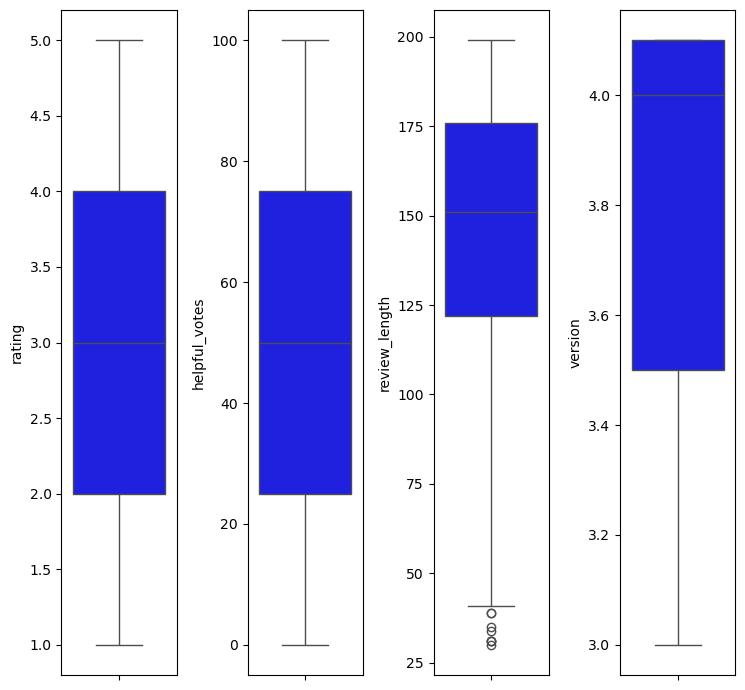

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
features = ['rating', 'helpful_votes','review_length','version']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df[features[i]],color='blue',)
    plt.tight_layout()

In [98]:
# Download the necessary NLTK data files (run this only once)
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [99]:
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords and lemmatize each word
    return ' '.join(words)

# Then apply the function
df['clean_review'] = df['review'].apply(clean_text)


In [100]:
def label_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)


In [ ]:
# df.to_csv(r'D:\project\ai_echo\4_ques.csv')

In [102]:
df.drop('review', axis=1, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13452\1319090466.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette = "viridis")


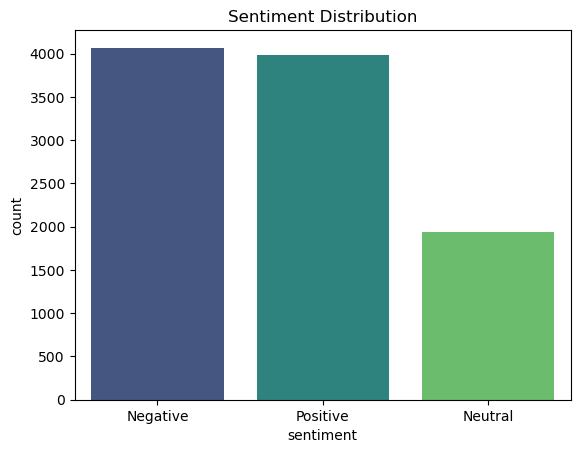

In [103]:
sns.countplot(x='sentiment', data=df, palette = "viridis")
plt.title('Sentiment Distribution')
plt.show()

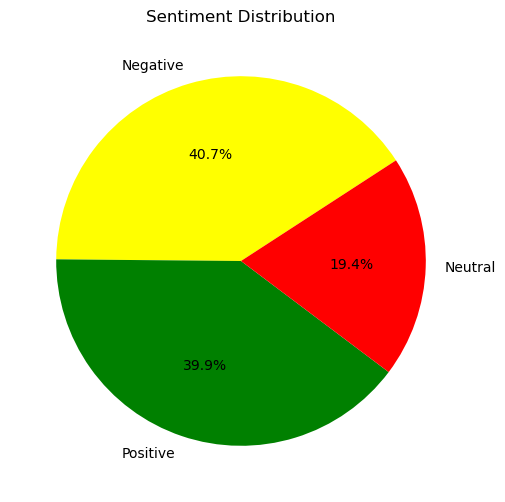

In [104]:
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=33, colors=['yellow', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


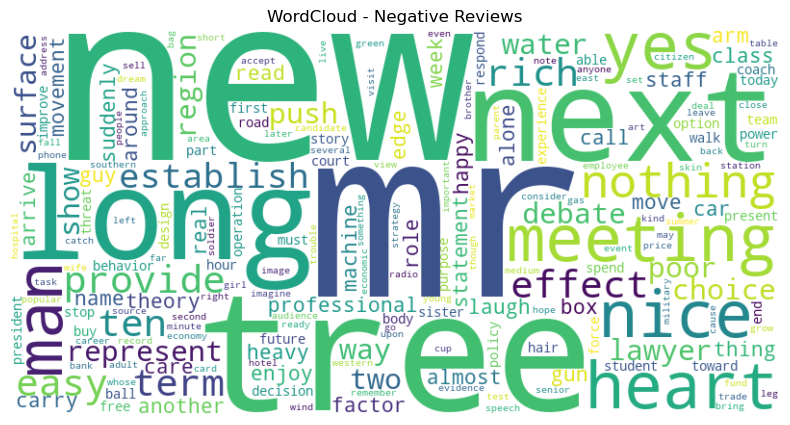

In [105]:
negative_text = ' '.join(df[df['sentiment'] == 'Negative']['clean_review'])

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Reviews')
plt.show()


In [106]:
df['sentiment'].value_counts()

sentiment
Negative    4069
Positive    3988
Neutral     1943
Name: count, dtype: int64

In [107]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13452\2060048014.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette='pastel')


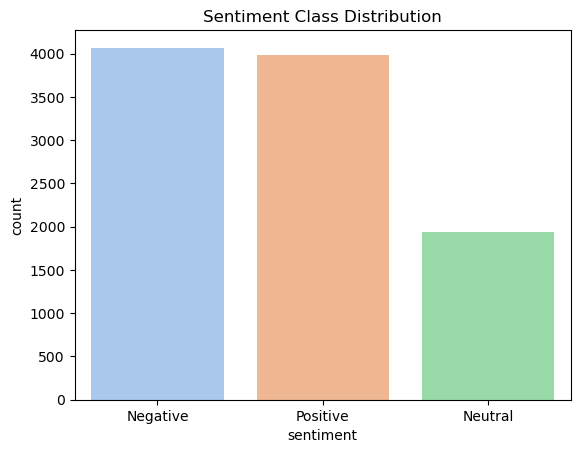

In [108]:
sns.countplot(x=df['sentiment'], palette='pastel')
plt.title("Sentiment Class Distribution")
plt.show()


In [109]:
# Separate classes
df_negative = df[df.sentiment == 'Negative']
df_neutral = df[df.sentiment == 'Neutral']
df_positive = df[df.sentiment == 'Positive']

# Downsample majority classes to match Neutral
df_negative_down = resample(df_negative, replace=False, n_samples=len(df_neutral), random_state=42)
df_positive_down = resample(df_positive, replace=False, n_samples=len(df_neutral), random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_negative_down, df_neutral, df_positive_down])


In [110]:
print(df_balanced['sentiment'].value_counts())


sentiment
Negative    1943
Neutral     1943
Positive    1943
Name: count, dtype: int64


In [111]:
print(df['username'].apply(type).unique())


[<class 'str'> <class 'datetime.datetime'>]


In [112]:
df['username'] = df['username'].apply(
    lambda x: str(x) if isinstance(x, datetime.datetime) else x
)


In [113]:
# Drop the original 'date' column
df = df.drop('date', axis=1)

In [114]:
# df.to_csv(r'D:\project\ai_echo\cleaned_reviews')

In [115]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_cols = ['platform', 'language', 'location', 'verified_purchase',
                     'title', 'clean_review','sentiment','username']	

# Initialize LabelEncoder
le = LabelEncoder()

# Apply encoding
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


EDA

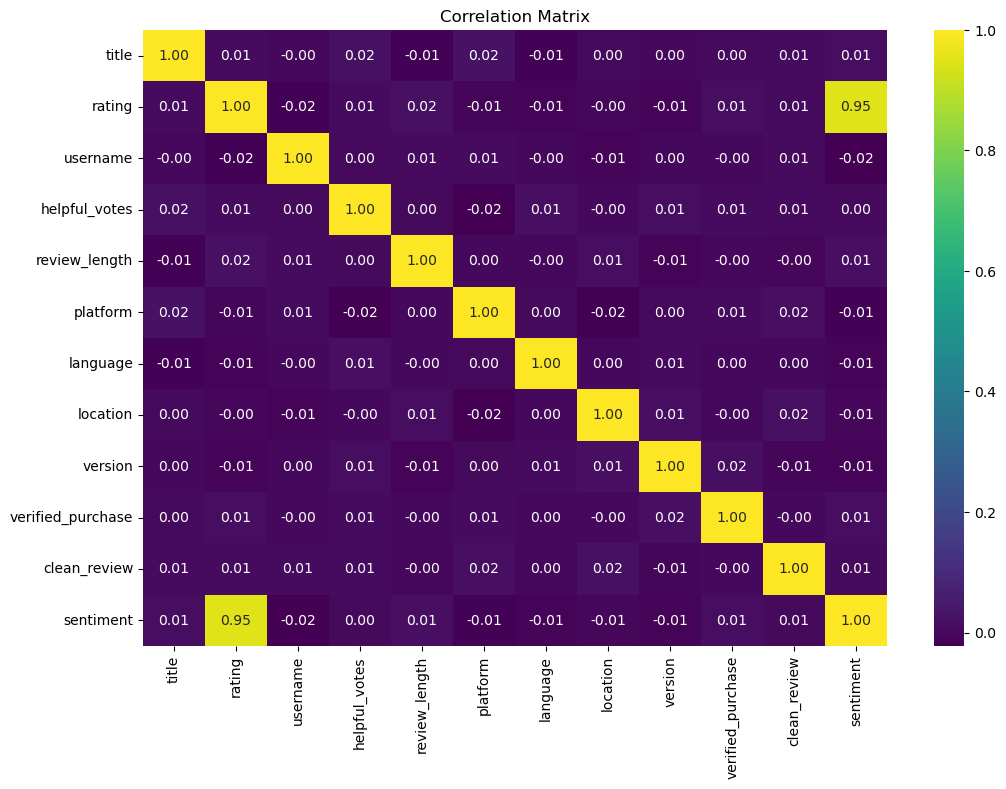

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Generate the correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13452\3044680253.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df,palette='colorblind')


Text(0.5, 1.0, 'Rating Distribution')

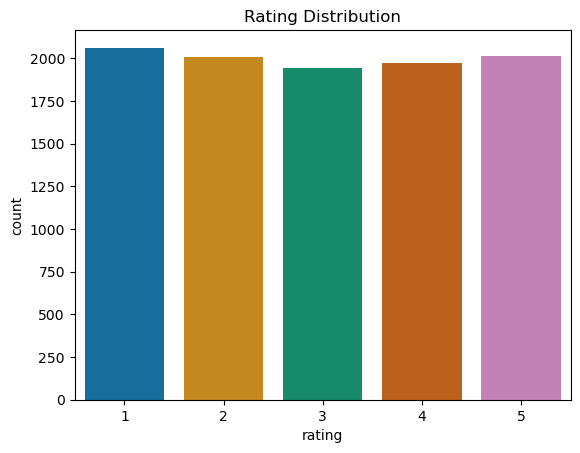

In [117]:
sns.countplot(x='rating', data=df,palette='colorblind')
plt.title('Rating Distribution')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13452\2217079265.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='rating', y='review_length',palette="muted")


Text(0.5, 1.0, 'Review Length by Rating')

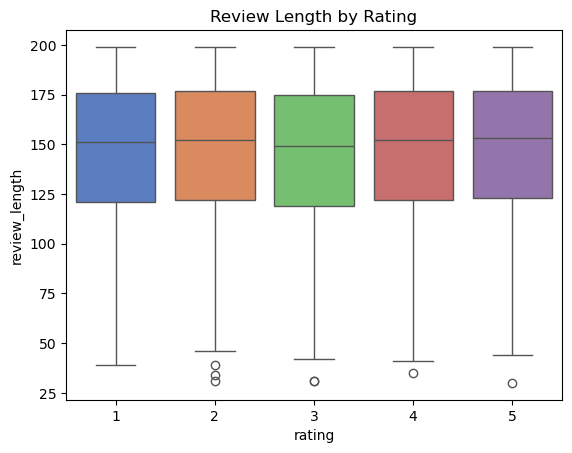

In [118]:
sns.boxplot(data=df,x='rating', y='review_length',palette="muted")
plt.title('Review Length by Rating')


Text(0.5, 1.0, 'Top 10 Locations by Review Count')

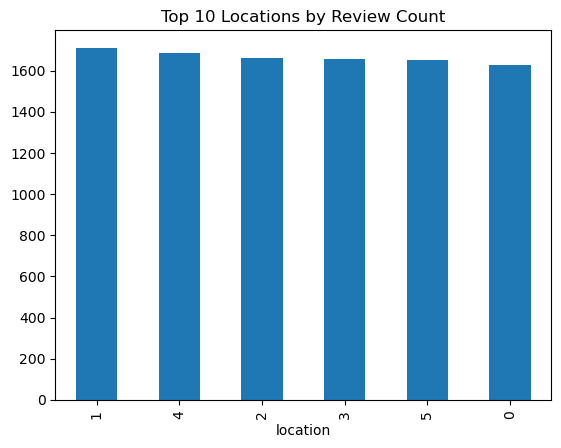

In [119]:
df['location'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Locations by Review Count')


Text(0.5, 1.0, 'Verified Purchase Distribution')

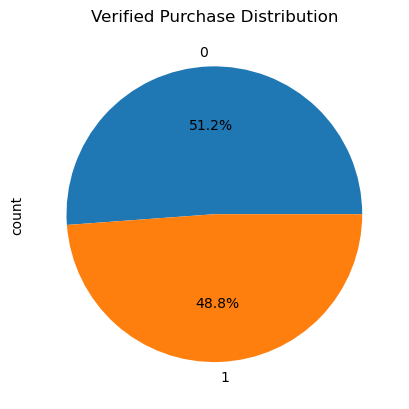

In [120]:
df['verified_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Verified Purchase Distribution')


Text(0.5, 1.0, 'Top 10 Active Users')

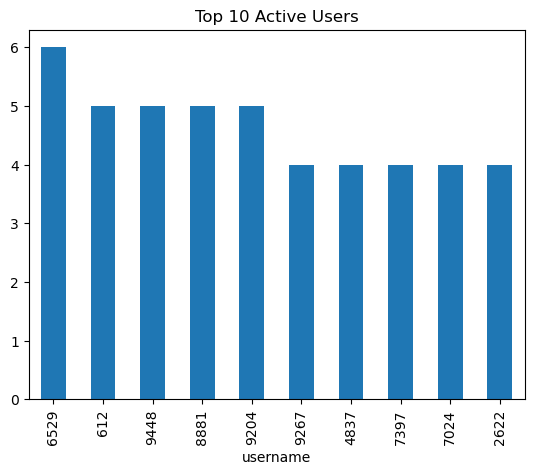

In [121]:
df['username'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Active Users')


Text(0.5, 1.0, 'Top Languages in Reviews')

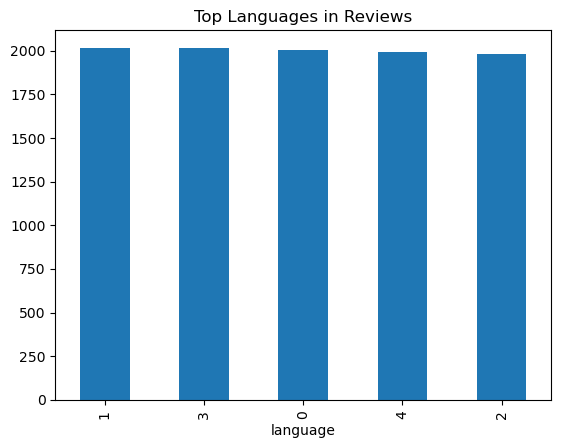

In [122]:
df['language'].value_counts().head(10).plot(kind='bar')
plt.title('Top Languages in Reviews')


Text(0.5, 1.0, 'Helpful Votes Across Ratings')

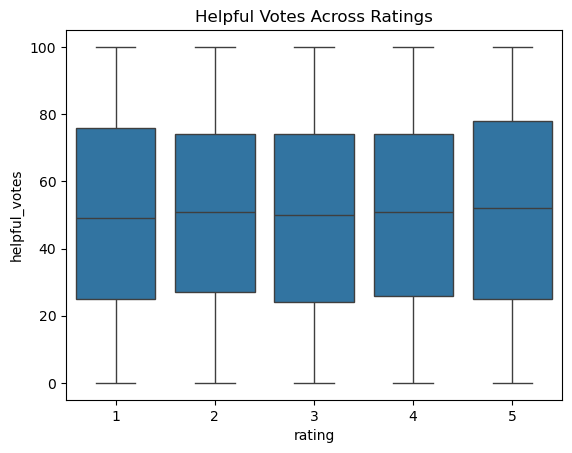

In [123]:
sns.boxplot(x='rating', y='helpful_votes', data=df)
plt.title('Helpful Votes Across Ratings')


In [124]:
# Assuming 'df' is your DataFrame and you want to drop columns for features
X = df.drop(['sentiment', 'helpful_votes', 'review_length'], axis=1)
y = df['sentiment']


In [125]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)


In [ ]:
# Vectorize the text
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)


# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       821
           1       1.00      1.00      1.00       388
           2       1.00      1.00      1.00       791

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



<Axes: >

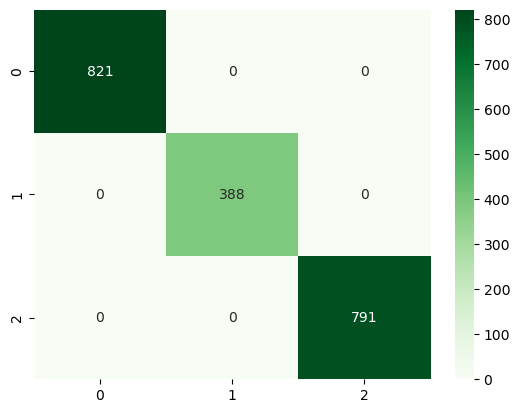

In [128]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')


In [129]:
print(f"Accuracy is {round(accuracy_score(y_test, model.predict(X_test))*100, 2)}%")

Accuracy is 100.0%


In [130]:
# Your original feature names
feature_names = X.columns.tolist()  # Ensure this matches your training features

# Sample input
input_data = pd.DataFrame([[1, 3, 1614,1, 4, 0, 4.1, 0, 1325]], columns=feature_names)

# Direct prediction (no scaling required)
prediction = model.predict(input_data)

# Interpret prediction
if prediction[0] == 0:
    print("✅ The model predicts: **Negative Sentiment**")
elif prediction[0] == 2:
    print("⚠️ The model predicts: **Neutral Sentiment**")
else:
    print("🚀 The model predicts: **Positive Sentiment**")

🚀 The model predicts: **Positive Sentiment**


In [131]:
pickle.dump(model, open("NLP_model.pkl", 'wb'))

In [132]:
# loading the saved model
loaded_model = pickle.load(open('NLP_model.pkl', 'rb'))

In [133]:
for column in X.columns:
  print(column)

title
rating
username
platform
language
location
version
verified_purchase
clean_review


In [134]:
# df.to_csv(r'D:\project\ai_echo\cleaned_data.csv')